# Model - Multinomial Naive Bayes

We have chosen to use Multinomial Naive Bayes because of its simplicity and because it has been known to perform well with text data with high dimensionality. Multinomial Naive Bayes algorithm attempts to classify text into categories (intents) so that the chatbot can identify the intent of the user and narrow down to the most possible range of responses.The algorithm does this by relying on commonality; words are given weight for particular categories based on their frequency of appearance in that category.

In [1]:
import json
import pandas as pd
import numpy as np 

from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
with open('../Final_Intents.json', 'r') as file:
    intents = json.load(file)

# formatting json to ensure keys read responses only
for entry in intents:
    if "answers" in entry:
        entry["responses"] = entry.pop("answers")

intents_dict={}

QnA = []
tags = []

for intent in intents:
    for question in intent["questions"]:
        tags.append(intent["tag"])
        QnA.append(question)
    for res in intent["responses"]:
        tags.append(intent["tag"])
        QnA.append(res)

intents_dict["QnA"] = QnA
intents_dict["tags"] = tags


df =  pd.DataFrame(intents_dict, columns=["QnA", "tags"])

# set seed to ensure reproducibility when shuffling
np.random.seed(42)
# shuffle to reduce bias and imrpove generalization
df = df.sample(frac=1).reset_index(drop=True)

df

,QnA,tags
0,UX Design part-time classes are scheduled from...,Product_Design_UI/UX_Career_Opportunities
1,Learning both front-end and back-end technolog...,Software_Engineering_Course_Content
2,Is there a waiting list for courses that are f...,enrollment
3,Do these projects simulate real-world data sci...,Data_Science_Project_and_Hands-on_Experience
4,Can I apply if I don’t have a background in da...,Data_Science_Application_Process
...,...,...
1291,Some projects offer opportunities for collabor...,Data_Science_Project_and_Hands-on_Experience
1292,How does the course encourage interaction with...,Data_Science_Networking_and_Collaboration_Oppo...
1293,Online learning is designed to be as interacti...,Data_Science_Online_and_Offline_Learning_Modes
1294,What documents do I need to submit for enrollm...,enrollment_deadline


In [3]:
df['tags'].value_counts()

Data_Science_Career_Opportunities                 29
DevOps_Course_Information                         25
Data_Science_Project_and_Hands-on_Experience      24
Data_Science_Curriculum_Outline                   24
Data_Science_Course_Overview                      24
                                                  ..
Data_Science_Cybersecurity_Introduction           10
Data_Science_Online_and_Offline_Learning_Modes    10
Data_Science_Industry_Relevance                   10
Data_Science_Competitions_and_Challenges          10
Data_Ethics_and_Privacy                           10
Name: tags, Length: 75, dtype: int64

This shows a class imbalance because some "tags" appear more frequently than others. This imbalance will affect the performance of our algorithm;it may struggle to properly learn and make accurate predictions for the minority class, leading to biased results.

In [4]:
# Text Preprocessing
# Text Cleaning
df['QnA'] = df['QnA'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)
# Tokenization
df['QnA'] = df['QnA'].apply(word_tokenize)
# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['QnA'] =df['QnA'].apply(lambda x: [word for word in x if word not in stop_words])
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['QnA']= df['QnA'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# Joining tokens
# Combine the list of tokens back into a string 
df['QnA'] = df['QnA'].apply(lambda x: ' '.join(x))



In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['QnA'], df['tags'], test_size=0.2, random_state=42)

In [6]:
#  TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [7]:
# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)


In [8]:
# One-hot encode the oversampled target variable
ohe = OneHotEncoder()
y_resampled_encoded = ohe.fit_transform(pd.DataFrame(y_resampled).values.reshape(-1, 1))


In [9]:
# instantiate
model = MultinomialNB(alpha=0.1)
model.fit(X_resampled, y_resampled)


#Model evaluation
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred,zero_division=1))



Accuracy: 0.58
                                                         precision    recall  f1-score   support

                           Advanced_Data_Science_Topics       1.00      0.67      0.80         3
                                                Contact       1.00      1.00      1.00         3
                     Cybersecurity_Career_Opportunities       1.00      0.17      0.29         6
                           Cybersecurity_Certifications       0.60      1.00      0.75         3
                       Cybersecurity_Course_Information       0.75      1.00      0.86         3
                                Data_Ethics_and_Privacy       0.67      1.00      0.80         2
            Data_Science_Admission_Eligibility_Criteria       0.25      1.00      0.40         2
                       Data_Science_Application_Process       0.33      0.50      0.40         2
                  Data_Science_Applications_in_Business       0.67      0.50      0.57         4
              

In [10]:
# Evaluate the model on the test set
accuracy = model.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.58


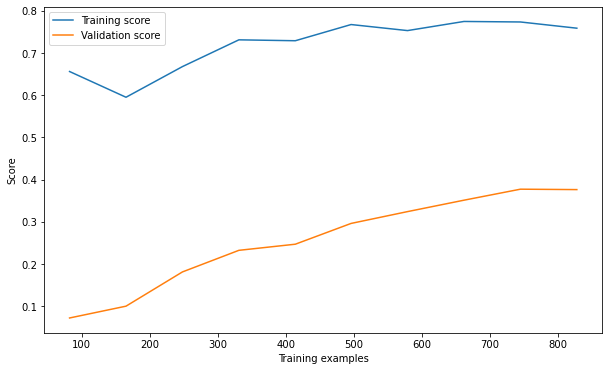

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


The training score intially drops, but then rises then plateaus. This shows that the model is learning more complex patterns in the training data. The testing score increases then plateaus, showing that the  model is generalizing better to the testing set as training progresses. However, there is a large gap between the two scores, indicating that the model is facing limitations.



In [ ]:
# Text Preprocessing

# Text Cleaning
df['questions'] = df['questions'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)

# Tokenization
df['questions'] = df['questions'].apply(word_tokenize)

# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['questions'] = df['questions'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['questions'] = df['questions'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


#Joining tokens
# Combine the list of tokens back into a string 
df['questions'] = df['questions'].apply(lambda x: ' '.join(x))


# ### Feature extraction
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['questions'])
X_tfidf

from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tfidf, df['tags'])


# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, 
                                                    random_state=42)



# instantiate
model = MultinomialNB(alpha=0.1)
model.fit(X_train, y_train)


#Model evaluation


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred,zero_division=1))

In [ ]:
import pandas as pd
with open('../Final_Intents.json', 'r') as file:
    intents = json.load(file)
    
intents_dict = {}

questions = []
tags = []
for intent in intents:
    for question in intent["questions"]:
        tags.append(intent["tag"])
        questions.append(question)

intents_dict["questions"] = questions
intents_dict["tags"] = tags


df =  pd.DataFrame(intents_dict, columns=["questions", "tags"])

# set seed to ensure reproducibility when shuffling
np.random.seed(42)
# shuffle to reduce bias and imrpove generalization
df = df.sample(frac=1).reset_index(drop=True)
df

In [ ]:
# Text Preprocessing

# Text Cleaning
df['questions'] = df['questions'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)

# Tokenization
df['questions'] = df['questions'].apply(word_tokenize)

# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['questions'] = df['questions'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['questions'] = df['questions'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


#Joining tokens
# Combine the list of tokens back into a string 
df['questions'] = df['questions'].apply(lambda x: ' '.join(x))



In [ ]:
# ### Feature extraction
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['questions'])
X_tfidf

In [ ]:
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tfidf, df['tags'])


# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, 
                                                    random_state=42)



# instantiate
model = MultinomialNB()
model.fit(X_train, y_train)


#Model evaluation


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred,zero_division=1))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()
